In [1]:
import numpy as np
import scipy as sc
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime, date
import calendar
from time import ctime

In [2]:
import matplotlib.pyplot as plt

from astropy.time import Time

from sunpy.coordinates import get_body_heliographic_stonyhurst


# Initial conditions with input parameters

In [3]:
#initia Conditions

Rs= 20              #in unit of solar radius
R0 = Rs*695700      # unit is Km
v0=1000            # unit is km/s
w=400              # which is ambient solar wind speed in unit of km/s 
Gamma=0.2
gamma=Gamma*10**(-7)  # unit is km-1
Time_UTC=datetime(2020,8,7,10,15,0)    #input utc time in format (year,month,date,hr,minute,second)


#Advance Drag based model parameter

Omega=30      # half angular width of CME in degree
Phi_target=20  # Earth-target heliocentric angular separation in degree 
Phi_CME=90     # source region central meridian distance in degree; shows shift of cme 

In [4]:
# defining equation of motion 

def dbm(x,t):
    r,v=x
    dxdt=[v,-gamma*(v-w)*np.abs(v-w)]
    return dxdt


ts = calendar.timegm(Time_UTC.timetuple())  #this command provide second correspond to given input time
t=np.arange(ts,ts+388000,1)

In [5]:
# Defining function to calculate speed and distance at alpha angle and solving equation of motion

def RV_alpha(omega,alpha):
    omega=np.deg2rad(omega)
    alpha=np.deg2rad(alpha)
    Y0=[R0,v0]
    Y=odeint(dbm,Y0,t)
    R=Y[:,0]/695700             # from now onwards we take solar radius as unit of distance
    V=Y[:,1]
    Ra=R *(np.cos(alpha) +((np.tan(omega))**2 - (np.sin(alpha))**2)**0.5)/(1+ np.tan(omega))
    Va= V *(np.cos(alpha) +((np.tan(omega))**2 - (np.sin(alpha))**2)**0.5)/(1+ np.tan(omega))
    
    return Ra,Va;

# Forecasting

In [6]:
# defining function for forecasting output

def find_nearest(d,v, value):
    array = np.asarray(d)
    idx = (np.abs(array - value)).argmin()
    v=float("{:.3f}".format(v[idx]))
    T=float("{:.3f}".format((t[idx]-t[0])/3600))
    T_Utc=datetime.utcfromtimestamp(t[idx])
    t_utcc_date = datetime.utcfromtimestamp(t[idx]).date().strftime('%d %b %Y')
    t_utcc_time = datetime.utcfromtimestamp(t[idx]).time().strftime('%H:%M:%S')

    print("Transit time of CME is " + str(T) +" hr")
    print("Impact Speed of CME at "+str(value) +" AU is " + str(v) + " km/s")
    print("Arrival time of CME " +str(value) +" AU in UTC is " +str(T_Utc))
    return idx,t_utcc_date,t_utcc_time,T_Utc


In [7]:
if Phi_CME-Omega < Phi_target < Phi_CME+Omega:
    print("Ohh no, CME hits the target.")
    alpha=np.abs(Phi_CME - Phi_target)
    R1=RV_alpha(Omega,alpha)[0]/215
    V1=RV_alpha(Omega,alpha)[1]
    A=find_nearest(R1,V1,1.0000)
    print(A[1])
    print(A[2])
    
else:
    print("Yeahh, CME misses the target")
    R1=RV_alpha(Omega,0)[0]/215
    V1=RV_alpha(Omega,0)[1]
    A=find_nearest(R1,V1,1.0000)
    print(A[1])
    print(A[2])
    

Yeahh, CME misses the target
Transit time of CME is 52.906 hr
Impact Speed of CME at 1.0 AU is 582.618 km/s
Arrival time of CME 1.0 AU in UTC is 2020-08-09 15:09:22
09 Aug 2020
15:09:22


# Plot of kinematic properties

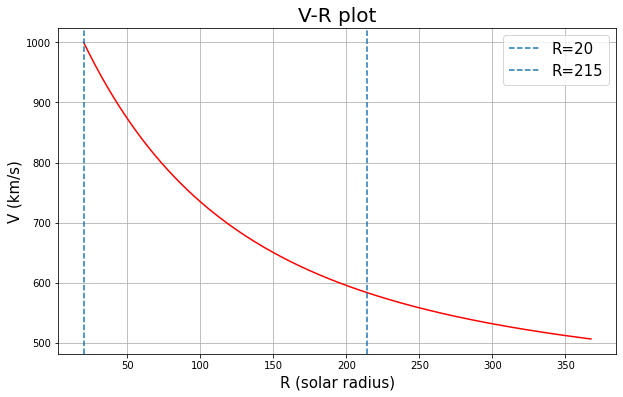

In [8]:
plt.figure(figsize=(10,6))
plt.plot(R1*215,V1,'r')
plt.axvline(x=20,linestyle="dashed",label="R=20")
plt.axvline(x=214,linestyle="dashed",label="R=215")
plt.xlabel("R (solar radius)",fontsize=15)
plt.ylabel("V (km/s)",fontsize=15)
plt.legend(fontsize=15)
plt.title("V-R plot", fontsize=20)
plt.grid()
plt.show()

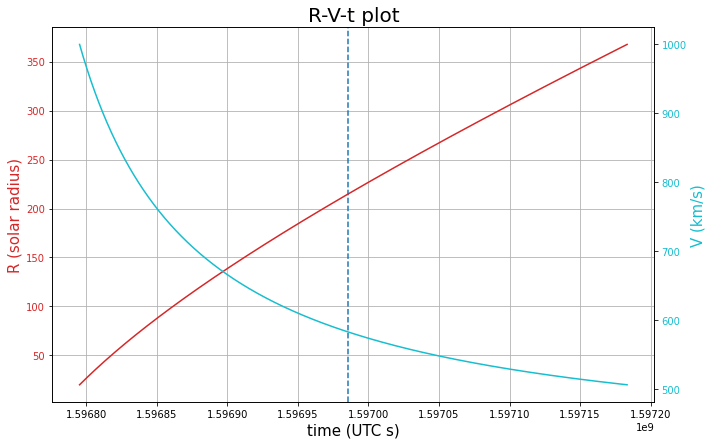

In [9]:
fig, ax1 = plt.subplots(figsize=(10,6))
plt.grid()
color = 'tab:red'
ax1.set_xlabel('time (UTC s)', fontsize=15)
ax1.set_ylabel('R (solar radius)', color=color,fontsize=15)
ax1.axvline(t[A[0]],linestyle="dashed")
ax1.plot(t, R1*215, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:cyan'
ax2.set_ylabel('V (km/s)', color=color,fontsize=15)  # we already handled the x-label with ax1
ax2.plot(t, V1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title("R-V-t plot", fontsize=20)
plt.show()

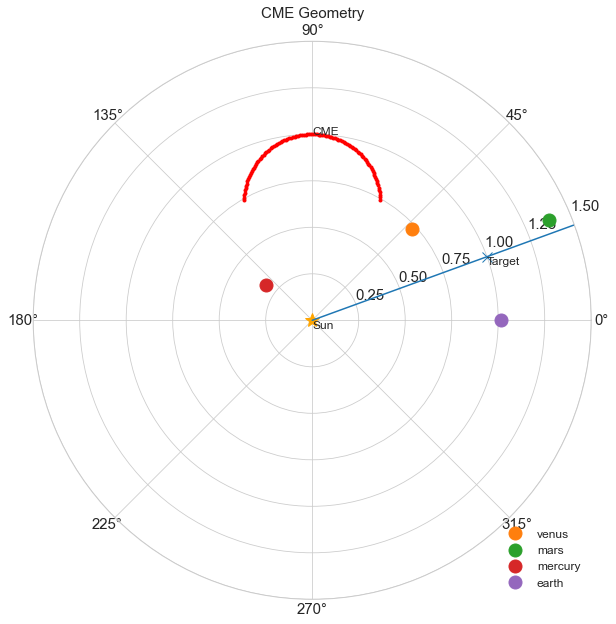

In [10]:
plt.figure(figsize=(10,15))
plt.style.use('seaborn-whitegrid')
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15) 
rads = np.arange(-2*np.pi,2* np.pi, 0.01) 


obstime =A[3]
planet_list = [ 'venus', 'mars', 'mercury','earth']
planet_coord = [get_body_heliographic_stonyhurst(this_planet, time=obstime) for this_planet in planet_list]


for rad in rads:
    if Phi_CME-Omega < np.rad2deg(rad) < Phi_CME+Omega:
        angle=np.abs(Phi_CME-np.rad2deg(rad))
        r=RV_alpha(Omega,angle)[0]
        q=r[A[0]]/215
        ax = plt.subplot(111, projection='polar')
        ax.plot(rad, q,'r.')
        
    else:
        pass

    
    
ax.set_rticks([0.25,0.5,0.75,1,1.25,1.5])
ax.set_ylim(0,1.5)

ax.plot(0,0,"*",markersize=15,color='orange')
ax.text(0,0,"Sun",fontsize=12,va='top')

#ax.plot(0,1,'o',markersize=10,color='green')
#ax.text(0,1,"Earth",fontsize=12,va='top')

ax.plot(np.deg2rad(Phi_target),1,'x',markersize=10)
ax.text(np.deg2rad(Phi_target),1,"Target",fontsize=12,va='top')
ax.axvline(np.deg2rad(Phi_target))

ax.text(np.deg2rad(Phi_CME),1,"CME",fontsize=12)

for this_planet, this_coord in zip(planet_list, planet_coord):
    ax.plot(this_coord.lon.to('rad'), this_coord.radius, 'o', label=this_planet,markersize=13)
ax.legend(loc=4,fontsize=12)

ax.set_title("CME Geometry",fontsize=15)
plt.show()